<H1>Conversations with Austin</H1>
<h2>Binary Classifier Template
<p> Tested with PyCaret 2.3.2
<p>

Wait ... who is Austin, you ask? Austin the Apex Duck is my [Rubber Duck Debug buddy](https:en.wikipedia.org/wiki/Rubber_duck_debugging). Usually a pretty quiet type of guy, but I sense hidden depths of knowledge. Our chats usually start with me staring at something for a long time, then asking a question something like: "Hey Austin, what do you know about Kappa?". His usual response is: "Kappa? Tell me more, please". This usually starts a back and forth dialogue where he eggs (no pun intended!) me on to explain more. He's all about putting things in writing, which is why I'm sitting here taking notes which I'm cataloguing in a series called "Chats with Austin".

Salil Athalye
www.bokehboy.com


Data provided by [DPhi Tech](https://dphi.tech//) Assignment 3: Advanced: Loan or No Loan?
https://dphi.tech/practice/challenge/54


# Configure Environment and Install Packages


In [1]:
!pip install pycaret[full] --quiet
!pip install mlflow --quiet
!pip install shap --quiet

     |████████████████████████████████| 266kB 30.5MB/s 
     |████████████████████████████████| 174kB 54.0MB/s 
     |████████████████████████████████| 6.8MB 37.6MB/s 
     |████████████████████████████████| 112kB 52.9MB/s 
     |████████████████████████████████| 256kB 46.3MB/s 
     |████████████████████████████████| 2.0MB 39.9MB/s 
     |████████████████████████████████| 276kB 50.2MB/s 
     |████████████████████████████████| 14.4MB 206kB/s 
     |████████████████████████████████| 1.7MB 42.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 1.4MB 37.4MB/s 
     |████████████████████████████████| 307kB 55.7MB/s 
     |████████████████████████████████| 166.7MB 85kB/s 
     |████████████████████████████████| 358kB 45.2

# Import Libraries


In [2]:
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import json
from google.colab import files
from google.colab import drive


# PyCaret
import pycaret
from pycaret.classification import * 
from pycaret.utils import enable_colab
enable_colab()


# MLflow
import mlflow
#TODO: How to set up an MLflow server which we can use with Colab? 
#mlflow.set_tracking_uri('file:/c:/users/mlflow-server')

import shap
#TODO: Not sure how PyCaret sets up shap.initjs() which is required for CoLab.

Colab mode enabled.


# Set Experiment Parameters


In [3]:
EXPERIMENT_NAME = 'churn_prediction_1'
SESSION_ID = 3435
DATA_SOURCE = "/content/drive/MyDrive/Livebook Datasets"
TRAINING_DATA = "livebook_dataset.csv"
TEST_DATA = "livebook_dataset_current.csv"
TARGET_COL = 'is_churn'
# Set this to False when converting this notebook to a Productions script
VERBOSE = True
# Optimize Threshold Costs (only for binary classifiers)
TP_COST = 0
TN_COST = 0
FP_COST = 0
FN_COST = 0
# Hyper-parameter search for model tuning
N_ITER = 10
# Should we download the run artifacts?
DOWNLOAD_ZIPFILE = True

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
MODEL = 'TBD' # we will populate this with the best model later

dt = datetime.now()
dt.replace(tzinfo=timezone.utc)
utc_timestamp = dt.replace(tzinfo=timezone.utc).isoformat(timespec='seconds')
# Replace ':' and '-' and retain up to seconds
UTC_TIMESTAMP = utc_timestamp.replace(':','').replace('-',"")[:15]

TRAINING_DATA_PATH = DATA_SOURCE + '/' + TRAINING_DATA
TEST_DATA_PATH = DATA_SOURCE + '/' + TEST_DATA

# Load the data


In [6]:
# Dataset is provided by DPhi Tech
# raw.githubusercontent.com allows us to download 'raw' content of files stored on github
# NOTE: the training data was most likely saved out without setting index=False, so we need to get rid of the index column on read.
# This is only an issue for the training data file, test data file is fine.
# Credit_History comes in as a float, due to missing values and how pandas manages na_type_promotions
# Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#na-type-promotions
dtype_mapping = {}
training_data  = pd.read_csv(TRAINING_DATA_PATH, dtype=dtype_mapping, index_col=[0])
test_data = pd.read_csv(TEST_DATA_PATH, dtype=dtype_mapping)

# Save the raw data in case the source is unavailable later
training_data.to_csv(TRAINING_DATA, index=False)
test_data.to_csv(TEST_DATA, index=False)
# Save any decisions we took on dtype mapping so we can reuse this in other applications
with open('dtype_mapping.json','w') as f:
  json.dump(dtype_mapping, f)

###Data Description
The measurements of the customers, also known as the “features” of the dataset, are described below:

is_churn - Indicator variable for whether or not the customer was retained or churned. This is the outcome or independent variable that you need to predict.

readingownedbook - how many events of reading a book the customer-owned

ebookdownloaded - how many times the customer download an e-book

readingfreepreview - how many times the customer read a free preview

highlightcreated - how many highlights the customer created

freecontentcheckout - how many times the customer use the free content check out feature

readingopenchapter - how many times the customer read on open (free) chapter

wishlistitemadded - How many times the customer added items to their wish list

crossreferencetermopened - how many times the customer opened a cross-reference term

total_events - what was the total number of events logged for the customer

distinct_products - how many distinct products did the customer purchase in the previous period

reading_utilities - how many times the customer used all reading utilities, including highlights and cross-reference terms

downloads_per_book - how many e-book downloads the customer had divided by the number of books they owned

percent_reading - the percent of the customers’ events that were reading

percent_utilities - the percent of the customers’ events that were utility features

events_per_book - the number of events the customer had divided by the distinct number of books they purchased



<p>
Target: is_churn, binary




In [7]:
test_data.shape

(59875, 17)

In [8]:
training_data.shape

(35020, 17)

### Compare Training Data Columns to Test Data Columns

In [9]:
training_data.columns

Index(['metric_time', 'is_churn', 'readingownedbook', 'ebookdownloaded',
       'readingfreepreview', 'highlightcreated', 'freecontentcheckout',
       'readingopenchapter', 'wishlistitemadded', 'crossreferencetermopened',
       'total_events', 'distinct_products', 'reading_utilities',
       'downloads_per_book', 'percent_reading', 'percent_utilities',
       'events_per_book'],
      dtype='object')

In [10]:
test_data.columns

Index(['account_id', 'last_metric_time', 'readingownedbook', 'ebookdownloaded',
       'readingfreepreview', 'highlightcreated', 'freecontentcheckout',
       'readingopenchapter', 'wishlistitemadded', 'crossreferencetermopened',
       'total_events', 'distinct_products', 'reading_utilities',
       'downloads_per_book', 'percent_reading', 'percent_utilities',
       'events_per_book'],
      dtype='object')

In [11]:
test_data.rename(columns={'last_metric_time':'metric_time'},inplace=True)

In [12]:
test_data_columns = test_data.columns
training_data_columns = training_data.columns
#Set difference : columns in training_data that are not in test_data
columns_missing_in_test = set(training_data_columns) - set(test_data_columns)
print(columns_missing_in_test)

{'is_churn'}


In [13]:
training_data.head(5)

metric_time  is_churn  readingownedbook  \
account_id                                                                 
0001b5d2fd33d5b98539d39658d69a90  2020-03-01      True              13.0   
00036f182bb0746fc8048d8e0bc785b3  2020-03-01      True               0.0   
0006aabe0ba47a35c0b0bf6596f85159  2020-03-01      True               0.0   
0006d94927acb83fdfae843f80d54507  2020-03-01      True               0.0   
000aa02f54c61c18c94096fc563115f8  2020-03-01      True               0.0   

                                  ebookdownloaded  readingfreepreview  \
account_id                                                              
0001b5d2fd33d5b98539d39658d69a90              0.0                 0.0   
00036f182bb0746fc8048d8e0bc785b3              1.0                 0.0   
0006aabe0ba47a35c0b0bf6596f85159              1.0                 0.0   
0006d94927acb83fdfae843f80d54507              1.0                 0.0   
000aa02f54c61c18c94096fc563115f8              4.0                 0.0   

                                  highlightcreated  freecontentcheckout  \
account_id                                                                
0001b5d2fd33d5b98539d39658d69a90               0.0                  0.0   
00036f182bb0746fc8048d8e0bc785b3               0.0                  0.0   
0006aabe0ba47a35c0b0bf6596f85159               0.0                  0.0   
0006d94927acb83fdfae843f80d54507               0.0                  0.0   
000aa02f54c61c18c94096fc563115f8               0.0                  0.0   

                                  readingopenchapter  wishlistitemadded  \
account_id                                                                
0001b5d2fd33d5b98539d39658d69a90                 0.0                0.0   
00036f182bb0746fc8048d8e0bc785b3                 0.0                0.0   
0006aabe0ba47a35c0b0bf6596f85159                 0.0                0.0   
0006d94927acb83fdfae843f80d54507                 0.0                0.0   
000aa02f54c61c18c94096fc563115f8                 0.0                0.0   

                                  crossreferencetermopened  total_events  \
account_id                                                                 
0001b5d2fd33d5b98539d39658d69a90                       0.0          16.0   
00036f182bb0746fc8048d8e0bc785b3                       0.0           1.0   
0006aabe0ba47a35c0b0bf6596f85159                       0.0           1.0   
0006d94927acb83fdfae843f80d54507                       0.0           2.0   
000aa02f54c61c18c94096fc563115f8                       0.0           4.0   

                                  distinct_products  reading_utilities  \
account_id                                                               
0001b5d2fd33d5b98539d39658d69a90                2.0                0.0   
00036f182bb0746fc8048d8e0bc785b3                1.0                0.0   
0006aabe0ba47a35c0b0bf6596f85159                1.0                0.0   
0006d94927acb83fdfae843f80d54507                1.0                0.0   
000aa02f54c61c18c94096fc563115f8                2.0                0.0   

                                  downloads_per_book  percent_reading  \
account_id                                                              
0001b5d2fd33d5b98539d39658d69a90                 0.0           0.8125   
00036f182bb0746fc8048d8e0bc785b3                 1.0           0.0000   
0006aabe0ba47a35c0b0bf6596f85159                 1.0           0.0000   
0006d94927acb83fdfae843f80d54507                 1.0           0.0000   
000aa02f54c61c18c94096fc563115f8                 2.0           0.0000   

                                  percent_utilities  events_per_book  
account_id                                                            
0001b5d2fd33d5b98539d39658d69a90                0.0              8.0  
00036f182bb0746fc8048d8e0bc785b3                0.0              1.0  
0006aabe0ba47a35c0b0bf6596f85159                0.0              1.0  
0006d94927acb83fd

In [14]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35020 entries, 0001b5d2fd33d5b98539d39658d69a90 to fffeba00a8c754f225bd9e707a1f224b
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   metric_time               35020 non-null  object 
 1   is_churn                  35020 non-null  bool   
 2   readingownedbook          35020 non-null  float64
 3   ebookdownloaded           35020 non-null  float64
 4   readingfreepreview        35020 non-null  float64
 5   highlightcreated          35020 non-null  float64
 6   freecontentcheckout       35020 non-null  float64
 7   readingopenchapter        35020 non-null  float64
 8   wishlistitemadded         35020 non-null  float64
 9   crossreferencetermopened  35020 non-null  float64
 10  total_events              35020 non-null  float64
 11  distinct_products         35020 non-null  float64
 12  reading_utilities         35020 non-null  float64
 13  download

In [15]:
training_data.isna().sum()

metric_time                 0
is_churn                    0
readingownedbook            0
ebookdownloaded             0
readingfreepreview          0
highlightcreated            0
freecontentcheckout         0
readingopenchapter          0
wishlistitemadded           0
crossreferencetermopened    0
total_events                0
distinct_products           0
reading_utilities           0
downloads_per_book          0
percent_reading             0
percent_utilities           0
events_per_book             0
dtype: int64

In [16]:
training_data.describe()

readingownedbook  ebookdownloaded  readingfreepreview  \
count      35020.000000     35020.000000        35020.000000   
mean           8.994003         3.551228            0.547287   
std           29.167386         9.421147            2.852418   
min            0.000000         0.000000            0.000000   
25%            0.000000         1.000000            0.000000   
50%            0.000000         1.000000            0.000000   
75%            5.000000         3.000000            0.000000   
max         1585.000000       530.000000          129.000000   

       highlightcreated  freecontentcheckout  readingopenchapter  \
count      35020.000000         35020.000000        35020.000000   
mean           1.562793             0.394917            0.685465   
std           24.977122             2.223385            4.808288   
min            0.000000             0.000000            0.000000   
25%            0.000000             0.000000            0.000000   
50%            0.000000             0.000000            0.000000   
75%            0.000000             0.000000            0.000000   
max         1230.000000           173.000000          386.000000   

       wishlistitemadded  crossreferencetermopened  total_events  \
count       35020.000000              35020.000000  35020.000000   
mean            0.366419                  0.555083     20.516219   
std             3.952971                  9.558913    124.888676   
min             0.000000                  0.000000      1.000000   
25%             0.000000                  0.000000      2.000000   
50%             0.000000                  0.000000      5.000000   
75%             0.000000                  0.000000     16.000000   
max           448.000000                873.000000  17301.000000   

       distinct_products  reading_utilities  downloads_per_book  \
count       35020.000000       35020.000000        35020.000000   
mean            4.015848           4.111965            0.953739   
std             6.929279          35.344279            1.020745   
min             1.000000           0.000000            0.000000   
25%             1.000000           0.000000            0.250000   
50%             2.000000           0.000000            1.000000   
75%             4.000000           2.000000            1.000000   
max           224.000000        2267.000000           39.000000   

       percent_reading  percent_utilities  events_per_book  
count     35020.000000       35020.000000     35020.000000  
mean          0.244412           0.103289         5.113183  
std           0.343724           0.189518        18.876640  
min           0.000000           0.000000         1.000000  
25%           0.000000           0.000000         1.000000  
50%           0.000000           0.000000         2.000000  
75%           0.500000           0.129630         4.000000  
max           1.000000           1.000000      2883.500000

In [17]:
training_data[TARGET_COL].value_counts()

True     24179
False    10841
Name: is_churn, dtype: int64

# Perform Basic Exploratory Data Analysis


# Set up the Experiment
### Notes
* Only set silent=True when you are sure that PyCaret has interpreted the type of each feature correctly. Also remember that if use the default (silent=False), **PyCaret will pause here**, waiting for user confirmation!!!
* When you migrate to Production in the form of a Python script then set html=False.


In [18]:
experiment = setup(training_data, 
                    target = TARGET_COL, 
                    session_id=SESSION_ID, 
                    #ignore_features=['Loan_ID'], # Loan_ID is a key
                    #numeric_features=['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term'],
                    imputation_type="iterative", 
                    categorical_iterative_imputer="lightgbm", 
                    numeric_iterative_imputer="lightgbm", 
                    iterative_imputation_iters = 5,
                    normalize = True,
                    fix_imbalance = True,
                    fix_imbalance_method = None, # will use SMOTE when set to None
                    fold_strategy='timeseries',
                    log_experiment = True,       # sets up MLflow using local files
                    log_plots=True,
                    log_data=True,
                    experiment_name = EXPERIMENT_NAME,
                    silent=True,                 # set to True only when you confirm feature types selected by PyCaret
                    #html=False                  # set to False when converting this to a Production script
                   )

Description                            Value
0                               session_id                             3435
1                                   Target                         is_churn
2                              Target Type                           Binary
3                            Label Encoded                False: 0, True: 1
4                            Original Data                      (35020, 17)
5                           Missing Values                            False
6                         Numeric Features                               15
7                     Categorical Features                                0
8                         Ordinal Features                            False
9                High Cardinality Features                            False
10                 High Cardinality Method                             None
11                   Transformed Train Set                      (24513, 19)
12                    Transformed Test Set                      (10507, 19)
13                      Shuffle Train-Test                             True
14                     Stratify Train-Test                            False
15                          Fold Generator                  TimeSeriesSplit
16                             Fold Number                               10
17                                CPU Jobs                               -1
18                                 Use GPU                            False
19                          Log Experiment                             True
20                         Experiment Name               churn_prediction_1
21                                     USI                             4caa
22                         Imputation Type                        iterative
23          Iterative Imputation Iteration                                5
24                         Numeric Imputer                             mean
25      Iterative Imputation Numeric Model  Light Gradient Boosting Machine
26                     Categorical Imputer                         constant
27  Iterative Imputation Categorical Model  Light Gradient Boosting Machine
28           Unknown Categoricals Handling                   least_frequent
29                               Normalize                             True
30                        Normalize Method                           zscore
31                          Transformation                            False
32                   Transformation Method                             None
33                                     PCA                            False
34                              PCA Method                             None
35                          PCA Components                             None
36                     Ignore Low Variance                            False
37                     Combine Rare Levels                            False
38                    Rare Level Threshold                             None
39                         Numeric Binning                            False
40                         Remove Outliers                            False
41                      Outliers Threshold                             None
42                Remove Multicollinearity                            False
43             Multicollinearity Threshold                             None
44             Remove Perfect Collinearity                             True
45                              Clustering                            False
46                    Clustering Iteration                             None
47                     Polynomial Features                            False
48                       Polynomial Degree                             None
49                    Trignometry Features                            False
50                    Polynomial Threshold                             None
51                          Group Features                            False
52 

#PyCaret Pipeline
PyCaret creates a Pipeline behind the scenes. Using get_config() we can output a description of the steps in the Pipeline.
<p>
TODO: Figure out how to save the pipeline description to JSON, perhaps?

In [19]:
prep_pipe = get_config('prep_pipe')

In [20]:
prep_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='is_churn',
                                      time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=False,
                                   classifier=LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_byt...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='is_churn')),
                (

# Feature Transformations
Review how PyCaret has transformed Features and the Target looking only at the training data to avoid data leakage.
This is useful when we start developing the front-end and the API so we can be specific on what categorical values are allowed.
<p>
TODO: Seems like we have to infer what transformations were made to each Feature. Would like to see something like col_a was Normalized, col_b was One Hot Encoded etc.

In [21]:
transformed_training_features = get_config('X_train')

In [22]:
transformed_training_features

readingownedbook  ...  metric_time_is_month_start_1
account_id                                          ...                              
e913c5915e513c21de962fc4211de99c          0.239450  ...                           1.0
bd43e8048d2d7d2792b4727ba3a526e5         -0.204694  ...                           1.0
1c35f53a2370ba439397254a980907cf         -0.307189  ...                           1.0
c6abce561f58d333cf4c19c4ac6d9de7         -0.307189  ...                           1.0
73c0e909e47023482255abe9d353990f         -0.307189  ...                           1.0
...                                            ...  ...                           ...
e0b89f1829240a36c7fa27c4d15c9116          0.478605  ...                           1.0
99a716e3f3036b3d193194c9222f3f49         -0.307189  ...                           1.0
4efd0d41239775e735f466fce4217462          0.717759  ...                           1.0
7e97a8fa3537bb0f604c8a33d5685dc7         -0.307189  ...                           1.0
01d0bc81d18a171357eff200f1da0c5a         -0.204694  ...                           1.0

[24513 rows x 19 columns]

#Evaluate, Select and Tune Model

## Compare Models


In [23]:
# return best model based on F1
best = compare_models(sort = 'F1', fold=5) #default is 'Accuracy'

Model  Accuracy     AUC  Recall   Prec.  \
nb                            Naive Bayes    0.7064  0.6797  0.9497  0.7163   
catboost              CatBoost Classifier    0.7213  0.7292  0.8082  0.7915   
svm                   SVM - Linear Kernel    0.7182  0.0000  0.8117  0.7863   
lr                    Logistic Regression    0.7216  0.7389  0.7948  0.7997   
xgboost         Extreme Gradient Boosting    0.7111  0.7063  0.8097  0.7795   
lightgbm  Light Gradient Boosting Machine    0.7131  0.7253  0.7972  0.7886   
gbc          Gradient Boosting Classifier    0.7137  0.7425  0.7709  0.8052   
ada                  Ada Boost Classifier    0.7137  0.7384  0.7645  0.8093   
rf               Random Forest Classifier    0.7033  0.6976  0.7901  0.7814   
ridge                    Ridge Classifier    0.7007  0.0000  0.7772  0.7857   
lda          Linear Discriminant Analysis    0.7005  0.7171  0.7769  0.7856   
et                 Extra Trees Classifier    0.6980  0.6881  0.7804  0.7809   
dt               Decision Tree Classifier    0.6740  0.5882  0.7748  0.7574   
knn                K Neighbors Classifier    0.6806  0.6683  0.7601  0.7722   
qda       Quadratic Discriminant Analysis    0.3114  0.0000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
nb        0.8166  0.1471  0.1938     0.302  
catboost  0.7998  0.3418  0.3421    14.054  
svm       0.7985  0.3300  0.3313     0.362  
lr        0.7972  0.3533  0.3534     0.870  
xgboost   0.7943  0.3101  0.3108     3.714  
lightgbm  0.7928  0.3262  0.3264     0.706  
gbc       0.7876  0.3491  0.3500     2.080  
ada       0.7862  0.3542  0.3556     0.828  
rf        0.7857  0.3033  0.3034     1.816  
ridge     0.7814  0.3067  0.3068     0.300  
lda       0.7812  0.3064  0.3065     0.306  
et        0.7806  0.2962  0.2963     1.526  
dt        0.7660  0.2293  0.2295     0.372  
knn       0.7655  0.2633  0.2641     1.956  
qda       0.0000  0.0000  0.0000     0.284

In [24]:
compare_model_results = pull()
compare_model_results.to_csv('compare_model.csv', index=False)

## Select the Base Model
### Notes for Austin
* Austin, when we want to study the decision boundaries that are established by different types of models, we can use create_model to run these experiments.

### Do your research!
* Is there a way to take the output from compare_models() and feed it into create model? Looks like compare_models() returns an object, whereas create_model needs a model identifier as a str.
* Future iteration, let's get a top N set of models that we can use for a bagging,blending,stacking foray! What would be a good criteria for going down this path? Can we establish a parallel path, or perhaps a choice?

In [25]:
# explicitly set MODEL - ideally would like to automate this by getting the model string from compare_models()
MODEL = 'xgboost'

In [26]:
# train base model
base_model = create_model(MODEL, verbose=True)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7092  0.6832  0.8196  0.7712  0.7947  0.2978  0.2994
1       0.7060  0.6862  0.8058  0.7748  0.7900  0.3007  0.3014
2       0.6831  0.6664  0.7939  0.7584  0.7757  0.2369  0.2377
3       0.6988  0.7133  0.8005  0.7709  0.7854  0.2811  0.2817
4       0.7204  0.7261  0.8282  0.7800  0.8034  0.3208  0.3226
5       0.7096  0.7165  0.8057  0.7754  0.7903  0.3189  0.3195
6       0.7374  0.7374  0.8237  0.8013  0.8123  0.3757  0.3761
7       0.7114  0.7199  0.8113  0.7804  0.7955  0.3057  0.3064
8       0.7195  0.7264  0.8024  0.7904  0.7964  0.3458  0.3459
9       0.7074  0.7175  0.7888  0.7898  0.7893  0.3106  0.3106
Mean    0.7103  0.7093  0.8080  0.7793  0.7933  0.3094  0.3101
SD      0.0135  0.0216  0.0121  0.0115  0.0094  0.0350  0.0348

In [27]:
create_model_results = pull()
create_model_results.to_csv('create_model.csv', index=False)

## Tune the Model


In [28]:

optimized_threshold = optimize_threshold(base_model, true_negative=TN_COST, false_negative=FN_COST, true_positive=TP_COST, false_positive=TN_COST)
print(optimized_threshold)


Optimized Probability Threshold: 0.0 | Optimized Cost Function: 0
0.0


In [29]:
optimized_threshold_results = {'TP_COST': TP_COST, 'TN_COST': TN_COST, 'FP_COST': FP_COST, 'FN_COST': FN_COST, 'OPT_THRESHOLD': optimized_threshold}
with open("optimized_threshold_results.json",'w') as f:
  json.dump(optimized_threshold_results, f)

In [30]:
# tune hyperparameters to optimize F1
tuned_model = tune_model(base_model, optimize = 'F1', n_iter=N_ITER)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7329  0.7177  0.9294  0.7449  0.8270  0.2718  0.3068
1       0.7280  0.7210  0.9529  0.7318  0.8278  0.2303  0.2844
2       0.7235  0.7115  0.9577  0.7278  0.8271  0.1975  0.2552
3       0.7298  0.7381  0.9589  0.7318  0.8301  0.2244  0.2841
4       0.7329  0.7522  0.9584  0.7350  0.8320  0.2333  0.2921
5       0.7271  0.7357  0.9643  0.7248  0.8276  0.2323  0.2996
6       0.7370  0.7561  0.9629  0.7367  0.8347  0.2430  0.3066
7       0.7352  0.7390  0.9630  0.7359  0.8343  0.2305  0.2940
8       0.7195  0.7465  0.9599  0.7216  0.8239  0.1979  0.2591
9       0.7356  0.7357  0.9593  0.7384  0.8345  0.2296  0.2885
Mean    0.7302  0.7354  0.9567  0.7329  0.8299  0.2291  0.2870
SD      0.0054  0.0140  0.0096  0.0065  0.0036  0.0201  0.0168

In [31]:
tune_model_results = pull()
tune_model_results.to_csv('tune_model.csv', index=False)

## Review Model Diagnostics
### Notes for Austin
* This is where we need to spend some quality time. Surfacing the insights from a set of runs to inform our next choices. Especially true when you are running complex models on cloud clusters --- the $$$ start to rack up.
* Let's invest in a deep study of these plots and formulate an approach

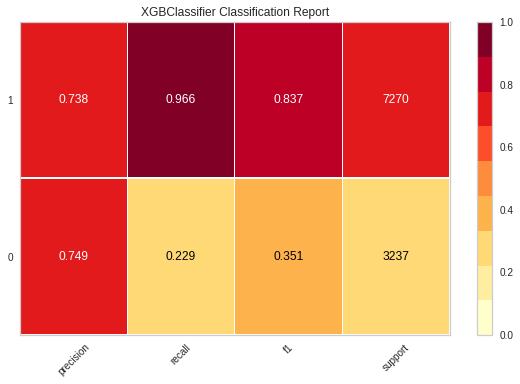

In [32]:
plot_model(tuned_model, plot = 'class_report')

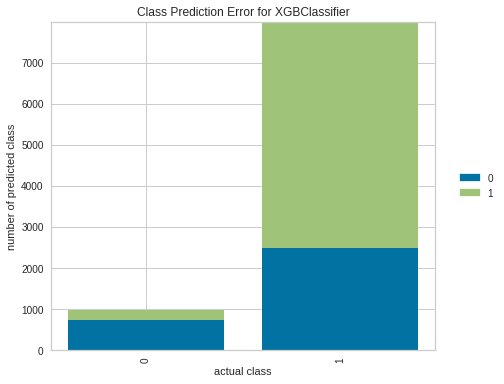

In [33]:
plot_model(tuned_model, plot='error')

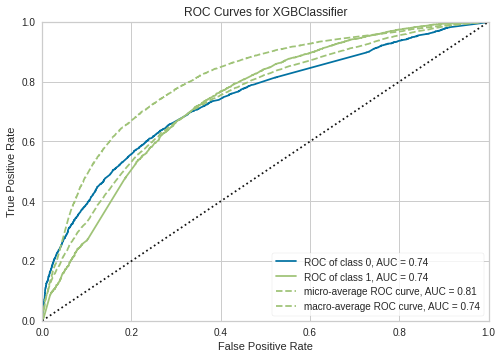

In [34]:
#plot a model
plot_model(tuned_model, plot='auc')

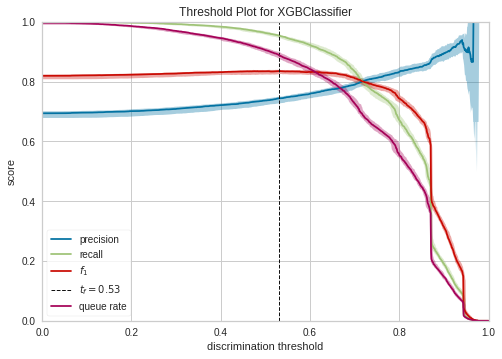

In [35]:
plot_model(tuned_model, plot='threshold')

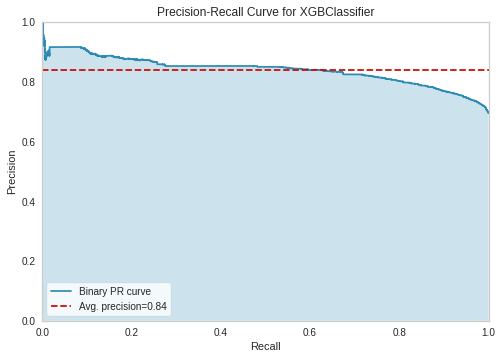

In [36]:
plot_model(tuned_model, plot = 'pr')

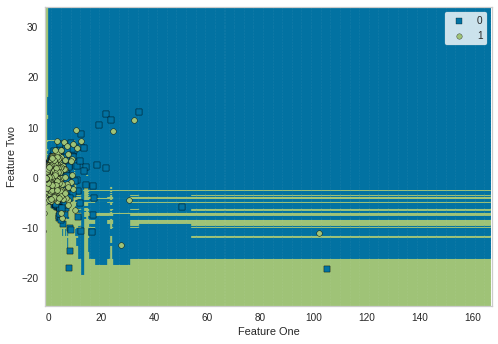

In [37]:
plot_model(tuned_model, plot='boundary')

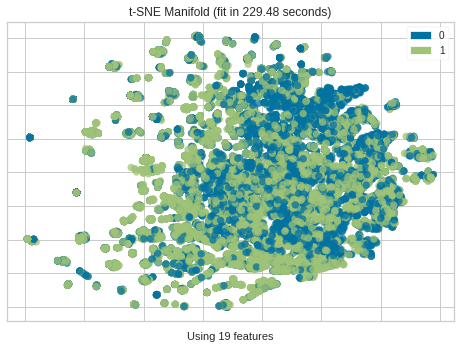

In [38]:
plot_model(tuned_model, plot='manifold')

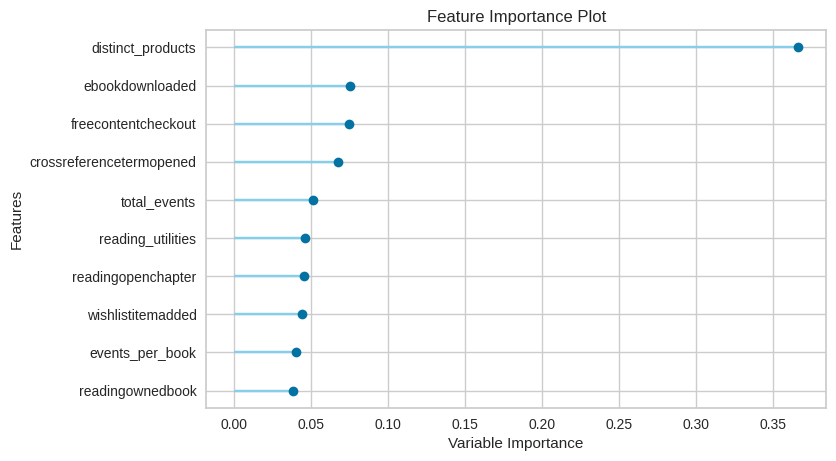

In [39]:

plot_model(tuned_model, plot='feature')

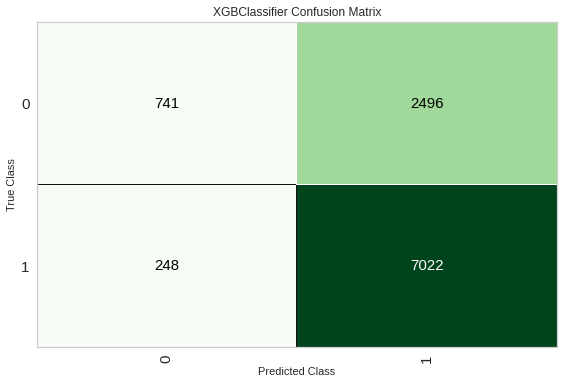

In [40]:
plot_model(tuned_model, plot = 'confusion_matrix')

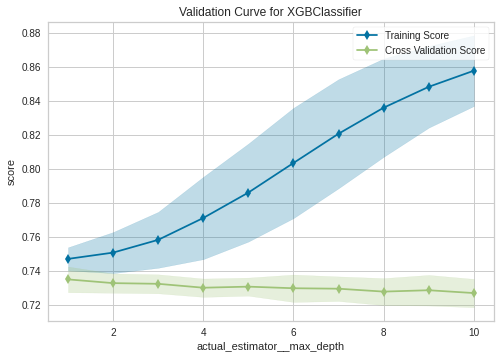

In [41]:
plot_model(tuned_model, plot='vc')

In [42]:
predict_model(tuned_model)

Model  Accuracy     AUC  ...      F1   Kappa    MCC
0  Extreme Gradient Boosting    0.7388  0.7394  ...  0.8365  0.2413  0.308

[1 rows x 8 columns]

readingownedbook  ebookdownloaded  ...  Label   Score
0              0.717759        -0.373360  ...   True  0.8201
1              3.348460        -0.373360  ...   True  0.9123
2              1.298563        -0.373360  ...   True  0.7075
3             -0.307189        -0.161455  ...   True  0.8635
4             -0.273024        -0.267408  ...   True  0.8412
...                 ...              ...  ...    ...     ...
10502         -0.307189         0.474260  ...   True  0.6157
10503         -0.307189        -0.267408  ...   True  0.8685
10504         -0.307189        -0.267408  ...   True  0.9443
10505         -0.307189        -0.267408  ...   True  0.7028
10506         -0.307189        -0.267408  ...   True  0.8685

[10507 rows x 22 columns]

##Interpret Model Predictions
<p>
If you are viewing this notebook on github, the next set of plots will not render as they require Javascript. SHAP interpretation

In [43]:
shap_models = ['xgboost', 'rf', 'catboost', 'et', 'lightgbm', 'dt']
run_shap = True if MODEL in shap_models else False
print(f'Cannot run SHAP model interpretation for {MODEL}' if run_shap == False else 'Running SHAP model interpretation. Plots require Javascript and may not render on github')

Running SHAP model interpretation. Plots require Javascript and may not render on github


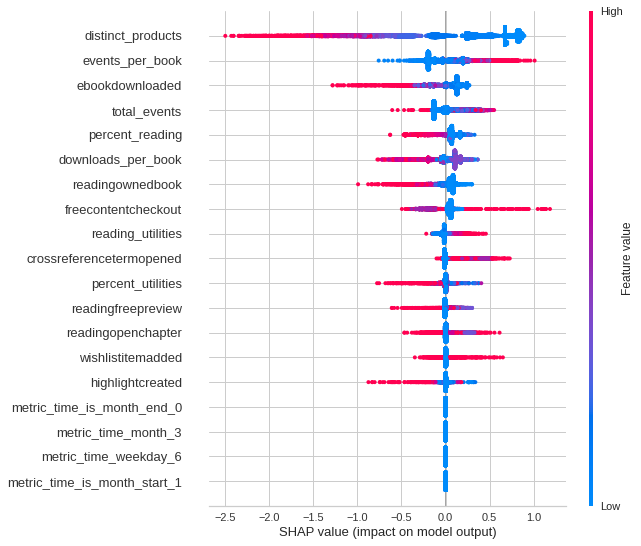

In [44]:
if run_shap:
  interpret_model(tuned_model)

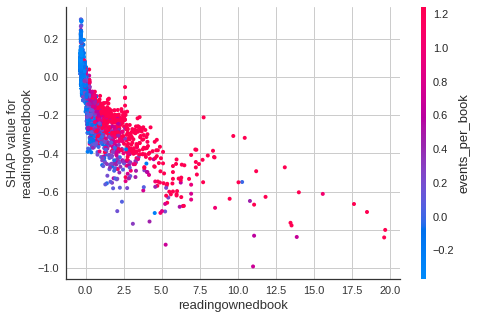

In [45]:
if run_shap:
  interpret_model(tuned_model, plot='correlation')

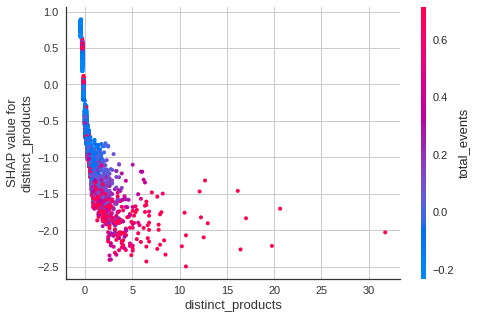

In [46]:
if run_shap:
  interpret_model(tuned_model, plot='correlation', feature='distinct_products')

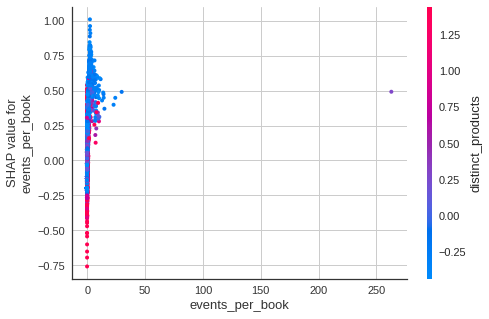

In [47]:
if run_shap:
  interpret_model(tuned_model, plot='correlation', feature='events_per_book')

In [48]:
#if run_shap:
#  interpret_model(tuned_model, plot='reason')

In [49]:
i = 77
if run_shap:
  interpret_model(tuned_model, plot='reason', observation = i)

1.1177057216657431


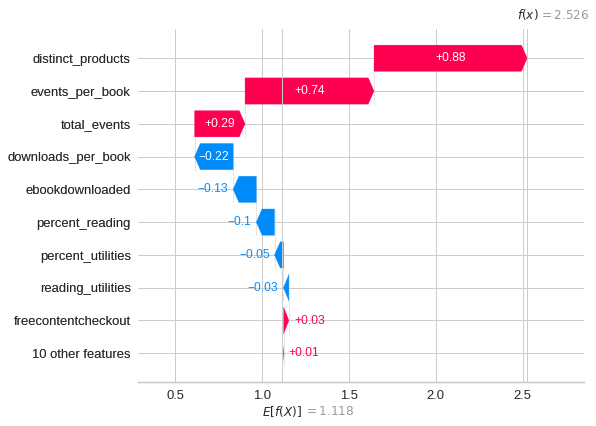

In [50]:
if run_shap:
  explainer = shap.TreeExplainer(tuned_model)
  base_value = explainer.expected_value[0]
  print(base_value)
  shap_values = explainer.shap_values(transformed_training_features)
  i = 77
  values = shap_values[i,:]
  features = transformed_training_features.columns
  data = transformed_training_features.iloc[i,:]
  # There is curently a bug in waterfall_plot, see
  # https://github.com/slundberg/shap/issues/1420
  # This is a workaround.
  shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=features)

In [51]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Finalize the Model

In [52]:
final_model = finalize_model(tuned_model)

In [53]:
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=3435, reg_alpha=1,
              reg_lambda=0.5, scale_pos_weight=2.8, subsample=0.7,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)


In [54]:
FINAL_MODEL_NAME_WITH_TS = EXPERIMENT_NAME + '_' + MODEL + '_' + UTC_TIMESTAMP
FINAL_MODEL_NAME_WITHOUT_TS = EXPERIMENT_NAME + '_' + MODEL

* Not sure if there are issues with putting a timestamp or a file name length constraint for cloud environments. I recall that Azure Machine Learning had an experiment name string length limit. For now, I will save the model again with a simple file name without the timestamp.

In [55]:
save_model(final_model, FINAL_MODEL_NAME_WITHOUT_TS)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='is_churn',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              colsample_byt...
                                interaction_constraints='', learning_rate=0.1,
                                max_delta_step=0, max_depth=4,
                                min_child_weight=1, missing=nan,
      

In [56]:
save_model(final_model, FINAL_MODEL_NAME_WITH_TS)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='is_churn',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              colsample_byt...
                                interaction_constraints='', learning_rate=0.1,
                                max_delta_step=0, max_depth=4,
                                min_child_weight=1, missing=nan,
      

In [57]:
!ls

catboost_info
churn_prediction_1_xgboost_20210718T190526.pkl
churn_prediction_1_xgboost.pkl
compare_model.csv
create_model.csv
drive
dtype_mapping.json
livebook_dataset.csv
livebook_dataset_current.csv
logs.log
mlruns
optimized_threshold_results.json
sample_data
tune_model.csv


# Load Model and Predict


In [58]:
loaded_model = load_model(FINAL_MODEL_NAME_WITHOUT_TS)

Transformation Pipeline and Model Successfully Loaded


In [59]:
loaded_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='is_churn',
                                      time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=False,
                                   classifier=LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_byt...
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                      

In [60]:
single_example = test_data.iloc[[1],:]

In [61]:
single_example.head()

account_id  ... events_per_book
1  000163671e7b29522ad47604f3b48cca  ...             1.0

[1 rows x 17 columns]

In [62]:
single_example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_id                1 non-null      object 
 1   metric_time               1 non-null      object 
 2   readingownedbook          1 non-null      float64
 3   ebookdownloaded           1 non-null      float64
 4   readingfreepreview        1 non-null      float64
 5   highlightcreated          1 non-null      float64
 6   freecontentcheckout       1 non-null      float64
 7   readingopenchapter        1 non-null      float64
 8   wishlistitemadded         1 non-null      float64
 9   crossreferencetermopened  1 non-null      float64
 10  total_events              1 non-null      float64
 11  distinct_products         1 non-null      float64
 12  reading_utilities         1 non-null      float64
 13  downloads_per_book        1 non-null      float64
 14  percent_readin

In [63]:
prediction = predict_model(loaded_model, data= single_example)

In [64]:
prediction

account_id metric_time  ...  Label   Score
1  000163671e7b29522ad47604f3b48cca  2020-05-31  ...   True  0.7267

[1 rows x 19 columns]

In [65]:
batch_prediction = predict_model(loaded_model, data=test_data)

In [66]:
batch_prediction

account_id metric_time  ...  Label   Score
0      00003e3b9e5336685200ae85d21b4f5e  2020-05-31  ...   True  0.8720
1      000163671e7b29522ad47604f3b48cca  2020-05-31  ...   True  0.7267
2      000183d7295b5898359736f76320843f  2020-05-31  ...   True  0.7455
3      0001b5d2fd33d5b98539d39658d69a90  2020-05-31  ...   True  0.6469
4      000274f21c484b0eb4960d7955599eac  2020-05-31  ...   True  0.8614
...                                 ...         ...  ...    ...     ...
59870  fffd61e63a1c045ec0cfd80e99b0367a  2020-05-31  ...   True  0.7606
59871  fffe12a49f485f6e4c420a46fd18a0ae  2020-05-31  ...   True  0.8461
59872  fffe8ed7af572cefb1fe4fbb86b0204a  2020-05-31  ...   True  0.5189
59873  fffeba00a8c754f225bd9e707a1f224b  2020-05-31  ...   True  0.9060
59874  ffff79edf0da15bf6085a3d7f4bd705f  2020-05-31  ...   True  0.9318

[59875 rows x 19 columns]

In [67]:
batch_prediction.to_csv('batch_predictions.csv', index=False)

In [68]:
submission = batch_prediction[['Label']]
submission.rename(columns={'Label':'prediction'}, inplace=True)
submission.index = test_data.index
submission.to_csv('prediction_results.csv', index=False)

In [69]:
logs = get_logs(save=True)
logs.head()

run_id  ...     tags.Source
0  dc7c31b2d35e43e7843f48297fd34245  ...  finalize_model
1  d6c141f499a24304a4bcd66835a805f5  ...      tune_model
2  e6999a0c51cf412f98bd024e1d1f3bc7  ...    create_model
3  37247d6fa0a947a99dce304f72bd2148  ...  compare_models
4  783bb2fffd8c4eec9fde7ba351938d49  ...  compare_models

[5 rows x 175 columns]

# Capture Schema Information



In [70]:
import json

def schema_to_json(df, filename_prefix):
  '''
  Adapted from
  Source: https://stackoverflow.com/questions/50422404/save-and-export-dtypes-information-of-a-python-pandas-dataframe
  '''
  columns_filename = filename_prefix + '_columns.json'
  df.head(0).to_json(columns_filename)

  tmp = df.dtypes.to_frame('dtypes').reset_index()
  df_dtypes = tmp.set_index('index')['dtypes'].astype(str).to_dict()
  dtypes_filename = filename_prefix + '_dtypes.json'
  with open(dtypes_filename, 'w') as f:
    json.dump(df_dtypes, f)

In [71]:
schema_to_json(training_data, 'training_data')
schema_to_json(test_data, 'test_data')

# Capture Package Versions


In [72]:
'''
Adapted from
Source: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
'''
package_versions = {m.__name__ : m.__version__ for m in globals().values() if getattr(m, '__version__', None)}
with open('notebook_package_versions.json','w') as f:
  json.dump(package_versions, f)

# Bundle Outputs and Download

In [73]:
# Google Colab places a folder of sample data in sample_data. We don't need that.
!rm -rf sample_data ||:

In [74]:
drive.flush_and_unmount()

In [75]:
ZIP_ARCHIVE_NAME = FINAL_MODEL_NAME_WITH_TS + '.zip'

In [76]:
!zip -qr ./$ZIP_ARCHIVE_NAME ./

In [77]:
if DOWNLOAD_ZIPFILE:
  files.download(ZIP_ARCHIVE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>